## Exploratory Data Analysis

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [2]:
train = pd.read_csv('./train_alldata_EDA.csv')
test = pd.read_csv('./test_alldata_EDA.csv')

In [3]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [4]:
# Dividing the train data into attack and non-attack category
normal = train[train['label']==0]
anomaly = train[train['label']==1]

## Correlation

Getting correlation values for all the features.

Plot heatmap of correaltion for better visualization

## Utility functions

In [5]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [6]:
def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

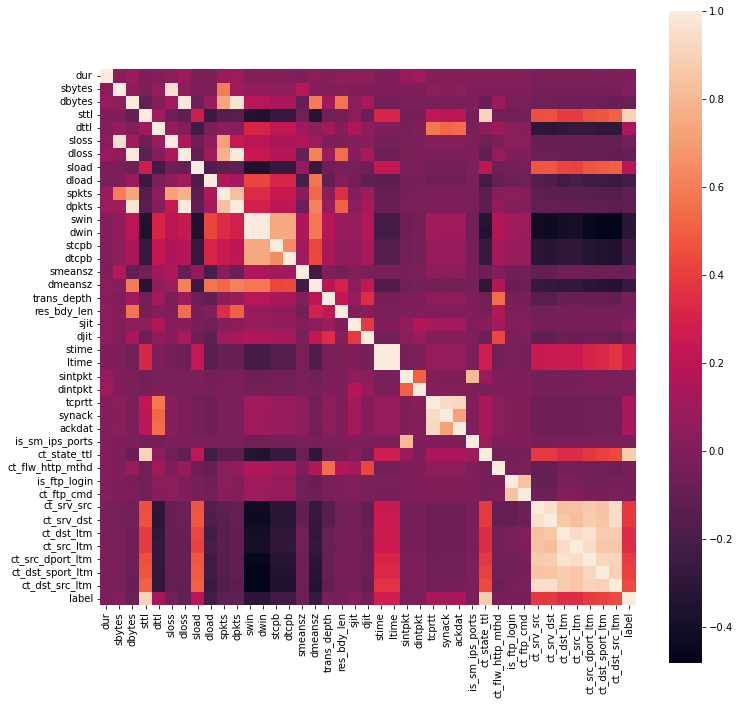

In [7]:
# Plotting the correlation matrix of the dataset
# Refer: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [8]:
# Getting and printing high correlated features
limit = 0.9

columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

sbytes               sloss                0.9515464133660682
dbytes               dloss                0.9912941785427634
dbytes               dpkts                0.9705744719061106
sttl                 ct_state_ttl         0.9058027624589845
sttl                 label                0.9043459910087561
dloss                dpkts                0.9921743916746946
swin                 dwin                 0.9971933359586712
stime                ltime                0.9999999998073185
tcprtt               synack               0.9332414134584018
tcprtt               ackdat               0.9202047490089745
ct_srv_src           ct_srv_dst           0.956721026945663
ct_srv_src           ct_dst_src_ltm       0.942148711061324
ct_srv_dst           ct_dst_src_ltm       0.9510250540010916
ct_dst_ltm           ct_src_ltm           0.9384612565049639
ct_dst_ltm           ct_src_dport_ltm     0.9601144948755526
ct_src_ltm           ct_src_dport_ltm     0.9453045008443021
ct_src_dport_ltm     ct_ds

## Pairplots of highly correlated features

### sbytes and sloss

These features are having very high corr between them more 95%
All the features are following a straight line except for the starting points that means they are having incresing relation with each other.

In [ ]:
sns.set_style("whitegrid")
sns.pairplot(data=train, vars=['sbytes', 'sloss'])
plt.show()

### dpkts, dbytes and dloss

1.These features are also showing same charecteristics as above.

2."dpkts" and "dbytes" are following a strainght line except for first few point and have 97% corr.

3."dloss" and "dbytes" are completely following straight line with more than 99% corr.


In [ ]:
sns.set_style('whitegrid')
sns.pairplot(train, vars=['dpkts', 'dbytes', 'dloss'])
plt.show()

### sttl, ct_state_ttl, label

1.sttl and ct_state_ttl are having 90% correlation between them.
But one important thing to notice that these 2 features are also highly correlated with target features i.e, label.

Going to drop 1 feature, and the remaining feature could play a vital role for the classification task.

In [ ]:
sns.set_style('whitegrid')
sns.pairplot(train, vars=['sttl', 'ct_state_ttl', 'label'])
plt.show()

### swin, dwin

swin: Source TCP window advertisement, dwin: Destination TCP window advertisement

Correlation values is 99% between them. Even though these 2 columns are numerical but most of their values are only 0 and 255.


In [ ]:
sns.set_style('whitegrid')
sns.pairplot(train, vars=['swin', 'dwin'])
plt.show()

### tcprtt, synack and ackdat

synack: The time between the SYN and the SYN_ACK packets of the TCP.
ackdat: The time between the SYN_ACK and the ACK ackets of the TCP.
tcprtt: sum of above 2 columns.

1.There are some similarity between "tcprtt" and "synack" and "tcsprtt" and "actdat" as value of x increases value of y also increases.

2.But for "synack" and "ackdat" values are scattered all over. And its corr value also not over 90%

In [ ]:
sns.set_style('whitegrid')
sns.pairplot(train, vars=['tcprtt', 'synack', 'ackdat'])
plt.show()

### ct_srv_src, ct_srv_dst and ct_dst_src_ltm

1.Range of all the features are between 0 to 60.

2.Most of the values are close to 0 and less than 10.

3.Values are well scattered but there are clear line that means have some linear relationship.

In [ ]:
sns.pairplot(train, vars=['ct_srv_src', 'ct_srv_dst', 'ct_dst_src_ltm'])
plt.show()

### ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm and ct_dst_sport_ltm

1.values range from 0 to 60.
2.Most of the values are close to 0 and lesser than 20.
3.ct_dst_ltm highly corr with ct_dst_sport_ltm
4.ct_src_ltm corr with ct_src_dport_ltm
5.ct_src_dport_ltm corr with ct_dst_sport_ltm

In [ ]:
sns.pairplot(train, vars=['ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm'])
plt.show()

### Countplots and pdf of features

Utility functions

In [ ]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Plotting pdf of numerical columns
# Refer: https://www.kaggle.com/khairulislam/unsw-nb15-eda

def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):
    """
    This function plots pdf of the given feature on attack and non-attck data
    """
    if method != None:
        sns.set_style('whitegrid')
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.set_style('whitegrid')
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()

In [ ]:
def reduce_column(s, to_keep):
    """
    This function reduce categorical values of a given feature to values provided in to_keep list
    and make every other value "others"
    """
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

### Attack Category

The name of each attack category. In this data set, there are total nine categories of attack and normal is non-attack.

The data is highly imbalanced and have lots of non-attack than attacks.

In train data most occured attack data categories are "Generic", "Exploits", Fuzzers", "DoS" and "Reconnaissance"

In [ ]:
col_countplot('attack_cat')

### Proto

Categorical feature. Transaction protocol

1. The no of unique values of 'proto' in dataset where attack is normal is 7 but in anamoly category its 129. So to plot it we are reducing the no of values.
2. Most of the values are consists of udp and tcp
3. For non-attacks count of tcp is lot higher
4. Considering the imbalce there are lots of udp cat for attacks

In [ ]:
train['proto'].nunique()

In [ ]:
normal['proto'].nunique(), anomaly['proto'].nunique()

In [ ]:
train['proto'].value_counts().head(10)*100/train.shape[0]

In [ ]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

In [ ]:
col_countplot('proto_reduced')

### Service

Categorical Features

1.In our dataset we can value "-" that is null, we need to remove that and replace it.
2.For normal there are lots of others that means most of "-" and few rare values.
3.In attack data "dns" is present higher than any other values. There are few no of others and http also.

In [ ]:
train['service'].nunique()

In [ ]:
train['service'].value_counts()

In [ ]:
to_keep = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
train['service_reduced'] = train['service'].apply(reduce_column, args=(to_keep,))

In [ ]:
col_countplot('service_reduced')

### State

Categorical feature. The state and its dependent protocol

Reducing very rare values with "others" to plot and visualize better

1.For non-attacks "fin" is very frequent then "cons" almost half of "fin" and few "int" also.
2.In attack "int" is higher than normal cat values. That could be really important feature to detect. There are very few "fin"

In [ ]:
train['state'].nunique()

In [ ]:
train['state'].value_counts()

In [ ]:
to_keep = ['int', 'fin', 'con', 'req']
train['state_reduced'] = train['state'].apply(reduce_column, args=(to_keep,))

In [ ]:
col_countplot('state_reduced')

In [ ]:
train.drop(columns=['proto_reduced', 'state_reduced', 'service_reduced'], inplace=True)

In [ ]:
train.shape

### ct_dst_ltm

Numerical feature.
No. of connections of the same destination address in 100 connections according to the last time.

1.Range of values of this feature is about 0 to 70
2.For normal data most of the values are between 0 to 10 and few from 10 to 20.
3.For anomaly values are close to 0 and also there are values from 10 to 30.
4.Can visualize better after using log1p on the feature

In [ ]:
col = 'ct_dst_ltm'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### ct_flw_http_mthd

Numerical feature with small discreate set of values.
No. of flows that has methods such as Get and Post in http service.

1.For normal almost all the values are 0 and few 1.
2.In attack data everything is 0 and there is very very litle no of 1's

In [ ]:
train['ct_flw_http_mthd'].nunique()

In [ ]:
col_countplot('ct_flw_http_mthd')

### ct_srv_src

Numerical feature.
No. of connections that contain the same service and source address in 100 connections according to the last time.

1.Range of the values is between 0 to 70.
2.For normal most of the values are from 0 to 15.
3.For anomaly most of the values are from 0 to 10 and the values are also distributed between 15 to 50.

In [ ]:
col = 'ct_srv_src'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### ct_state_ttl

Numerical feature with small discrete set of values.

1.normal data has 0 as most of its values.
2.anomaly has most of its value 2.
3.There are few attack with value 1 to and also very little non-attack with 1.

In [ ]:
train['ct_state_ttl'].nunique()

In [ ]:
col_countplot('ct_state_ttl')

### dinpkt

Numerical feature. Destination inter-packet arrival time (mSec)

1.This feature has 55 unique values.
2.Most of the non-attack data has value 1 and there are very very litte 2,3,4, 19,21,23 but they are very less in number not visible in the graoh also.
3.Attck data has value 0 most no of time but that is also way too little compared with non-attack data.

### ct_dst_sport_ltm


In [ ]:
train['ct_dst_sport_ltm'].nunique()

In [ ]:
col_countplot('ct_dst_sport_ltm')

### dintpkt

Numerical feature.
Destination inter-packet arrival time (mSec)

1.Feature has large range of values upto 60,000
2.For nonmal data there is a very high peek from 15,000 to 20,000
3.For attack data values are distributed in first 10000

In [ ]:
train['dintpkt'].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('dintpkt')
plt.subplot(122)
dual_plot('dintpkt', method=np.log1p)
plt.show()

### djit

Numerical feature. Destination jitter (mSec)

1.Range of this feature is huge upto 800,000.
2.Normal data distributed over very wide range upto 200,000.
3.For attack data there is a huge peek close to 0 and distributioon of values are very narrow.

In [ ]:
train['djit'].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('djit')
plt.subplot(122)
dual_plot('djit', method=np.log1p)
plt.show()

### dload

Numerical feature. Destination bits per second

1.This feature has high correlation with target feat, 0.35
2.Feature has huge range of values upto 1e8
3.We can visualize better in log scale. For normal data they are distributed all over, has values close to 0 and also very large values
4.And for attack data all the values are very close to 0. IN log scale we can see that values are between 3 to 15

In [ ]:
train['dload'].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('dload')
plt.subplot(122)
dual_plot('dload', method=np.log1p)
plt.show()

### dbytes

Numerical feature. Destination to source bytes.

1.The range of values for this feature is very wide upto 1e7.
2.Values of normal categories are grouped together. In log scale can see there are values close to 0 and then from 5 to 12.
3.For attck category data values are widely spread. In log scale can see high peeks around 5 to 7.

In [ ]:
col = 'dbytes'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### dmeansz

Numerical feature. Mean of the flow packet size transmitted by the dst

1.Feature range between 0 to 1600, with high corr with "label" 0.29
2.For non-attck data most values are between 0-200. And few of them are distributed from 400 to 800
3.Most of the values in anomaly from 0 to 100.

In [ ]:
col = 'dmeansz'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### dpkts

Numerical feature. Destination to source packet count

1.Range of values for this feature is around 10,000
2.Non-attck cat values are very close to 0. In log scale its upto 5.
3.Attack cat values are widely distributed and has higher fraction around 2 and 3 in log1p graph

In [ ]:
train['dpkts'].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('dpkts')
plt.subplot(122)
dual_plot('dpkts', method=np.log1p)
plt.show()

### dtcpb

Numerical features. Destination TCP sequence number

1.The range of this feature is very very wide 4*10^9
2.Values of normal cat are lot more wide spread than anomaly cat.
3.From the graphs its not much clear about the distribution. But can see attack cat values are distributed through out total range.

In [ ]:
col = 'dtcpb'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### dttl

Destination to source time to live
Numerical feature with only 11 unique value. Can plot it as categorical feature.

Destination to source time to live

1.Most of the values for non-attack data is 29. There are some 0 and very few 252.
2.There lots of 0 in attack data, no of 0 in attack is more than non-attack, there are few 252 also and that is also higher than non-attack.

In [ ]:
train['dttl'].nunique()

In [ ]:
col_countplot('dttl')

### dur

Numerical feature. Record total duration

1.Range of this feature is 0 to 8000
2.Both attack and non-attack cat values are very close to 0.
3.But attack cat values are widely distributed than non-attack.

In [ ]:
col = 'dur'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### sintpkt

Numerical feature. Source inter-packet arrival time (mSec)

Most of the values in normat cat is close to 0 and spread to 400. And few values are also close to max value of the feature.
anomaly cat has most of values near to 0 and spread is less compared to normal

In [ ]:
train['sintpkt'].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot('sintpkt')
plt.subplot(122)
dual_plot('sintpkt', method=np.log1p)
plt.show()

### sttl

Numerical feature with only 13 unique value.
Source to destination time to live

1.normal cat data has most of its values 31 and few 60.
2.anomaly cat has almost all of its value 254.

In [ ]:
train['sttl'].nunique()

In [ ]:
col_countplot("sttl")

### stcpb

Numerical feature. Source TCP sequence number

1.The graphs are very similar to 'dtcpb'
2.normal cat has higher no of values close to 0 and has spread through out whole range
3.anomaly has most of its values near 0 and less spread compared to normal cat.

In [ ]:
col = 'stcpb'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()

### swin

Numerical feature with 22 unique value.
Source TCP window advertisement

1.Most of the values of this feature are just 0 and 255
2.Normal cat data has most of its values 255 and 0
3.Attack act has large no of 0 and small no of 255, just the inverse of normal cat.

In [ ]:
train['swin'].nunique()

In [ ]:
col_countplot('swin')

### sbytes

Source to destination bytes
Numerical feature with large range of values upto 1e7

1.Most of normal cat values are close to 0.
2.Attack cat has most of its values around 5 in log1p graph.
3.The spread of values is wider in attack compared to normal.

In [ ]:
col = 'sbytes'
train[col].nunique()

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(121)
dual_plot(col)
plt.subplot(122)
dual_plot(col, method=np.log1p)
plt.show()